In [1]:
## Generally setup
import numpy as np
import os
import os.path as op
import matplotlib.pyplot as plt
from langouEEG import *
from scipy.stats import *
from eeg_microstates3 import *
import pandas as pd
import time
import mne
import pickle
from mne.datasets import sample
from mne.datasets import fetch_fsaverage
from mpl_toolkits.mplot3d import Axes3D  # noqa
from langouMicrostates import *
from IPython.display import clear_output as clear
import logging
# import easyEEG

sample_data_folder = mne.datasets.sample.data_path()
# dataRoot = "/data/home/viscent/Light"
dataRoot = "/work/zhangyq/Light/"


# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
isMale = False
isAll = True
isBlind = False
if not isAll:
    result_dir = op.join(dataRoot,'result','male' if isMale else 'female')
else:
    result_dir = op.join(dataRoot,'result','all')
if isBlind:
    result_dir = op.join(result_dir,'Blind')
subjects_dir = op.dirname(fs_dir)
if not op.exists(result_dir):
    os.mkdir(result_dir)
# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
print(__doc__)

0 files missing from root.txt in /work/zhangyq/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /work/zhangyq/mne_data/MNE-fsaverage-data/fsaverage
Automatically created module for IPython interactive environment


In [2]:
%%capture
## Input EEG data and extarct epochs

epochs_4F = dict()
epochs_RF = dict()
epochs_4R = dict()
epochs_RR = dict()
#epochs_all = dict()


# tmin_rest, tmax_rest, tmin_flick,tmax_flick = 40, 60, 15, 30
# tmin_rest, tmax_rest, tmin_flick,tmax_flick = 40, 50, 15, 22
tmin_rest, tmax_rest, tmin_flick,tmax_flick = 5, 25, 5, 25
# tmin_R_flick, tmax_R_flick = 20, 25
# tmin_R_flick, tmax_R_flick = 20, 22
tmin_R_flick, tmax_R_flick = 5, 25

# Total 1-21
# 1-11 and 12-21
epoch_num = 0
for subject_name in range(1,21):
    if not isAll:
        if not (isMale ^ (subject_name in [7,8,11,17])):
            continue
    if subject_name<10:
        subject_name='S0'+str(subject_name)
    else:
        subject_name='S'+str(subject_name)
    with open(dataRoot+'/clean_data_av/'+subject_name+'_clean.lgeeg','rb') as f:
        raw=pickle.load(f)
    events, event_dict=extractEvents(raw)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                        exclude='bads')
    if isBlind:
        epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochsBlind(raw,events,picks, 
        tmin_rest = 60,tmax_rest = 87,tmin_flick = 3,tmax_flick = 30)
    else:
        epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs_forall(raw,events,picks, 
        tmin_rest = tmin_rest,tmax_rest = tmax_rest,tmin_flick = tmin_flick,tmax_flick = tmax_flick)
        _,epoch_RF,_,_ = extractEpochs_forall(raw,events,picks, 
        tmin_rest = tmin_rest,tmax_rest = tmax_rest,tmin_flick = tmin_R_flick,tmax_flick = tmax_R_flick)
    epochs_4F[subject_name]=epoch_4F
    epochs_RF[subject_name]=epoch_RF
    epochs_RR[subject_name]=epoch_RR
    epochs_4R[subject_name]=epoch_4R
    #epochs_all[epoch_num] = epoch_4R
    #epochs_all[epoch_num+1] = epoch_4F
    #epochs_all[epoch_num+2] = epoch_RF
 
    if not op.exists(os.path.join(dataRoot,'fwd_solution.lgeeg')):
        fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                        bem=bem, eeg=True, mindist=5.0, n_jobs=1)
        print(fwd)
        mne.write_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'),fwd,overwrite=True)
    else:
        fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solution.lgeeg'))
    data_path = sample.data_path()

    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                        exclude='bads')

    epoch_num += 3
    # Clear output display
    clear()

## Concact epochs
epoch_4F = mne.concatenate_epochs(list(epochs_4F.values()))
epoch_RF = mne.concatenate_epochs(list(epochs_RF.values()))
epoch_4R = mne.concatenate_epochs(list(epochs_4R.values()))
# epoch_all = mne.concatenate_epochs(list(epochs_all.values()))
# mne.epochs.equalize_epoch_counts([epoch_4F, epoch_RF, epoch_RR])

# Clear output display
clear()

Not setting metadata
Not setting metadata
302 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped
(3020302, 64)


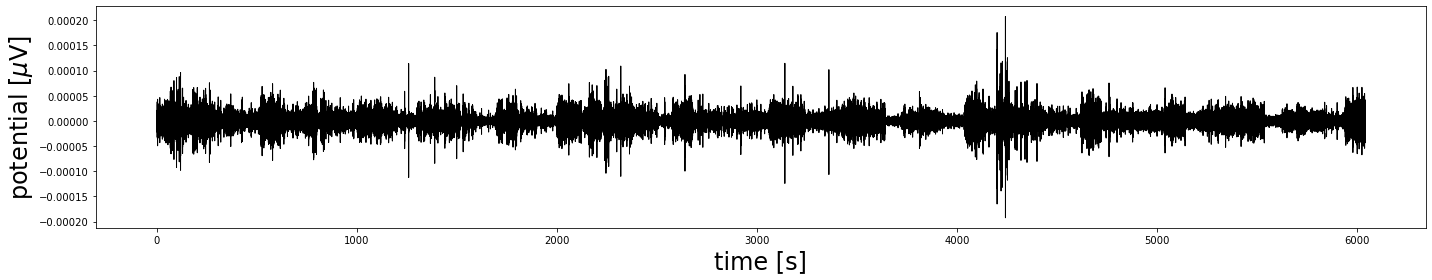

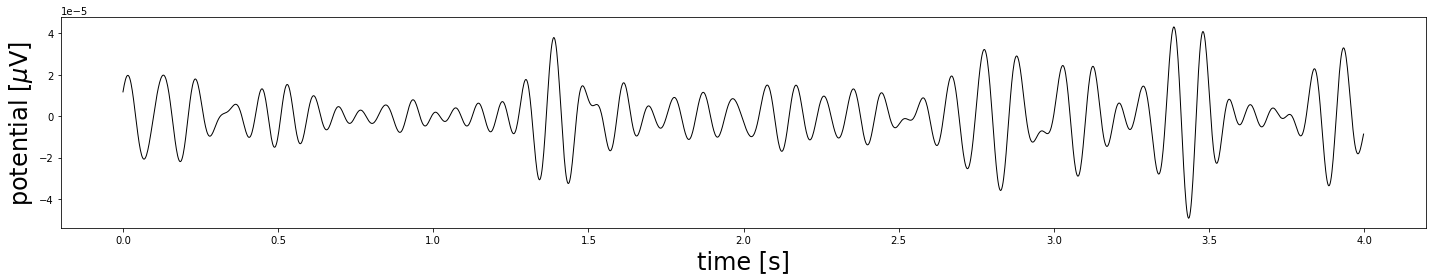

Clustering algorithm: kmeans
[+] Data format for clustering [GFP peaks, channels]: 126860 x 64

[+] Clustering algorithm: mod. K-MEANS.
	K-means run 1/5 converged after 63 iterations.
	K-means run 2/5 converged after 58 iterations.
	K-means run 3/5 converged after 108 iterations.
	K-means run 4/5 converged after 63 iterations.
	K-means run 5/5 converged after 63 iterations.
[+] Computation time: 79.14 sec

[+] Microstate back-fitting:
data_norm:  (3020302, 64)
data_cluster_norm:  (126860, 64)
maps:  (8, 64)

[+] Global explained variance GEV = 0.633
GEV_0: 0.024
GEV_1: 0.075
GEV_2: 0.065
GEV_3: 0.112
GEV_4: 0.091
GEV_5: 0.070
GEV_6: 0.104
GEV_7: 0.094

Empirical symbol distribution (RTT):

p_0 = 0.122
p_1 = 0.219
p_2 = 0.003
p_3 = 0.007
p_4 = 0.147
p_5 = 0.208
p_6 = 0.187
p_7 = 0.106

Empirical transition matrix:

|0.8450.0350.0010.0020.0290.0350.0360.017|
|0.0200.8720.0000.0010.0210.0460.0260.013|
|0.0240.0250.8240.0210.0160.0270.0300.032|
|0.0360.0400.0090.7630.0280.0440.0380.042|
|0

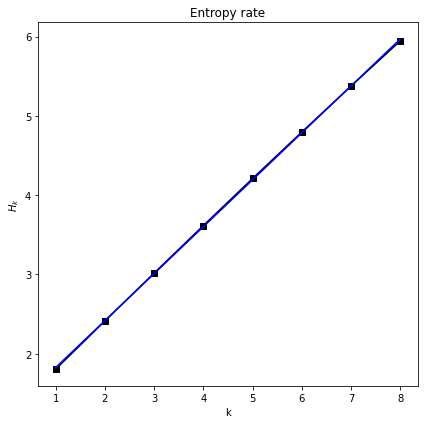


Empirical entropy rate h = 0.59
Theoretical MC entropy rate h = 0.61


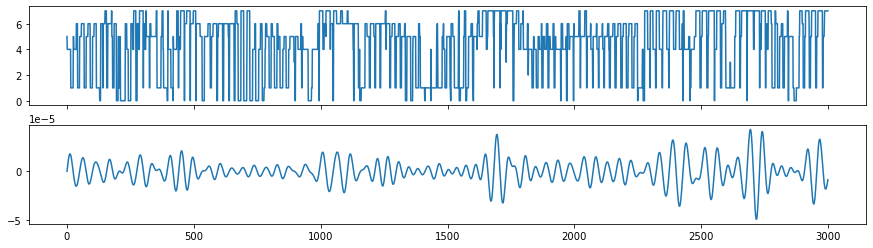

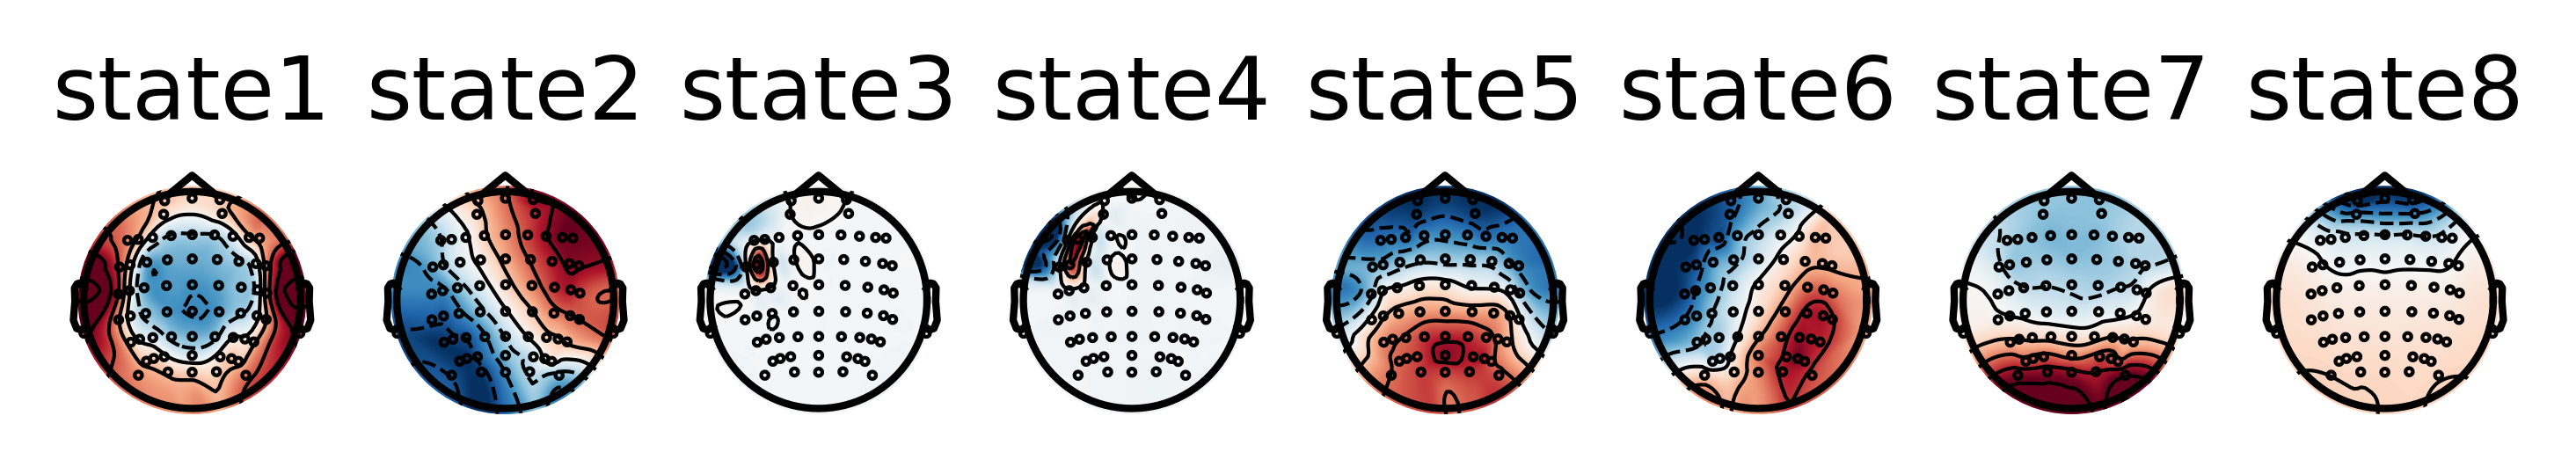

In [3]:
epochs_order = list(epochs_4R.values())
for i in list(epochs_4F.values()):
    epochs_order.append(i)
for i in list(epochs_RF.values()):
    epochs_order.append(i)
epoch_order = mne.concatenate_epochs(epochs_order)

dataRoot = "/work/zhangyq/Light/"

result_dir = dataRoot + "result/microstates"
tm = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())
time_augs=[['min_rest','max_rest','min_flick','max_flick','min_random_flick','max_random_flick']
,[tmin_rest, tmax_rest, tmin_flick, tmax_flick, tmin_R_flick, tmax_R_flick]]

# Args to save MS result
save = False
to_save_cache = False
save_log = False

from langouEEG import *
vars_all = display_maps(epoch_order, n_maps=8, save=save, dpi=600, filename='all',
fmt='.png', to_save_cache=to_save_cache, time_augs=time_augs, tm=tm, result_dir=result_dir,
calc_lzc=False, epochs=epoch_order,save_log=save_log, f_lo=8, f_hi=13)

In [5]:
# vars: vars_all, vars_4R, vars_4F, vars_RF
# For vars_: 0:maps, 1:x, 2:gfp_peaks, 3:gev, 4:data, 5:pca1
vars_4R = display_maps(epoch_4R, n_maps=4, save=save, dpi=600, filename='40Hz_rest',
fmt='.png', to_save_cache=to_save_cache, time_augs=time_augs, tm=tm, result_dir=result_dir,
calc_lzc=False, epochs=epochs_4R,save_log=save_log, f_lo=8, f_hi=13)

vars_4F = display_maps(epoch_4F, n_maps=4, save=save, dpi=600, filename='40Hz_flicker', 
fmt='.png', to_save_cache=to_save_cache, time_augs=time_augs, tm=tm, result_dir=result_dir,
calc_lzc=False, epochs=epochs_4F,save_log=save_log,f_lo=8, f_hi=13)

vars_RF = display_maps(epoch_RF, n_maps=4, save=save, dpi=600, filename='random_flicker', 
fmt='.png', to_save_cache=to_save_cache, time_augs=time_augs, tm=tm, result_dir=result_dir,
calc_lzc=False, epochs=epochs_RF,save_log=save_log,f_lo=8, f_hi=13)

In [29]:
print(vars_all[1].shape)
print(vars_4R[1].shape)
print(vars_4F[1].shape)
print(vars_RF[1].shape)

index_rest_end = vars_4R[1].shape[0]
index_40_end = index_rest_end + vars_4F[1].shape[0]
index_random_end = index_40_end + vars_RF[1].shape[0]
x_4R = vars_all[1][0: index_rest_end]
x_4F = vars_all[1][index_rest_end:index_40_end]
x_RF = vars_all[1][index_40_end:index_random_end]


(3020302,)
(1050105,)
(1020102,)
(950095,)


In [30]:
seq = [1,2,3,1,1,1,1,1,1,2,2,2,3,3,3,3,3,3]
seq = np.ndarray(seq)
def ms_reject(x, reject_time=30, fs=500):
    reject_num = reject_time/fs
